# showq dynamic analysis

## Preprocessing

The output of Adaptive Computing Moab `showq` command has to be preprocessed by `scripts/showq2csv.py`. It will create a CSV file that can be imported by pandas.

## Prerequisites

Import required modules.

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
%matplotlib inline

Ensure that modules are reloaded automatically when modified.

In [3]:
%load_ext autoreload
%autoreload 2

In [114]:
from lib.vsc.moab.nb_utils import extract_category
from lib.vsc.moab.metrics import (started_jobs, finished_jobs, new_jobs, moved_jobs, state_distribution,
                                  showq_timeseries)

## Analysis

Load the current and the previous showq data.

In [5]:
curr_df = pd.read_csv('data/showq_1528968510.csv', parse_dates=['time_stamp', 'datetime'])

In [6]:
prev_df = pd.read_csv('data/showq_1528967910.csv', parse_dates=['time_stamp', 'datetime'])

Which jobs have started since the last showq epoch? These are the jobs that are currently active, and were previously either idle or blocked.

In [7]:
curr_running_df = extract_category(curr_df, 'ActiveJob')

In [8]:
prev_idle_df = extract_category(prev_df, 'EligibleJob')

In [9]:
prev_blocked_df = extract_category(prev_df, 'BlockedJob')

In [28]:
started_df = started_jobs(curr_running=curr_running_df, prev_idle=prev_idle_df, prev_blocked=prev_blocked_df)
started_df

,category,time_stamp,job_id,user_id,state,procs,remaining,start_time,walltime_limit
0,ActiveJob,2018-06-14 11:28:30,20842191,vsc31821,Running,20,35429,2018-06-14 11:19:22,35977.0
1,ActiveJob,2018-06-14 11:28:30,20842195,vsc31835,Running,80,172601,2018-06-14 11:25:34,172777.0


So two jobs that were idle are now running. Which jobs were blocked and are now running?

Which jobs were idle, and are now blocked?

In [30]:
curr_blocked_df = extract_category(curr_df, 'BlockedJob')

In [31]:
moved_jobs(from_cat=prev_idle_df, to_cat=curr_blocked_df)

,category,time_stamp,job_id,user_id,state,procs,walltime_limit,queue_time,time_in_queue


How many jobs are idle now, and how many were idle in the previous epoch?

In [12]:
curr_idle_df = extract_category(curr_df, 'EligibleJob')

In [14]:
curr_idle_df.job_id.count(), prev_idle_df.job_id.count()

(116, 117)

## Time series

Analyze the state of jobs as a time series. The simplest representation is the number of jobs in a given state as a function of time.

In [111]:
directory = Path.cwd() / 'data'
pattern = 'showq_*.csv'
queue_timeseries = showq_timeseries(directory, pattern)

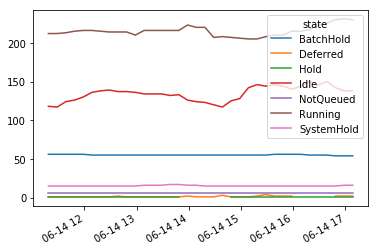

In [113]:
queue_timeseries.plot();

In [124]:
file_names = list(directory.glob(pattern))
prev_df = pd.read_csv(file_names.pop(0))
prev_running_df = extract_category(prev_df, 'AcitveJob')
prev_idle_df = extract_category(prev_df, 'EligibleJob')
prev_blocked_df = extract_category(prev_df, 'BlockedJob')
index = list()
data = {
    'started': list(),
    'finished': list(),
}
for file_name in directory.glob(pattern):
    curr_df = pd.read_csv(file_name)
    index.append(get_time_stamp(curr_df))
    curr_running_df = extract_category(curr_df, 'ActiveJob')
    started_df = started_jobs(curr_running=curr_running_df, prev_idle=prev_idle_df,
                              prev_blocked=prev_blocked_df)
    finished_df = finished_jobs(prev_running=prev_running_df, curr=curr_df)
    data['started'].append(len(started_df))
    data['finished'].append(-len(finished_df))
    prev_df = curr_df
    prev_running_df = curr_running_df
    prev_idle_df = extract_category(prev_df, 'EligibleJob')
    prev_blocked_df = extract_category(prev_df, 'BlockedJob')
diff_df = pd.DataFrame(data, index=index)
diff_df.sort_index(inplace=True)

In [125]:
diff_df.head(10)

,started,finished
2018-06-14 11:18:30,0,-6
2018-06-14 11:28:30,0,-27
2018-06-14 11:38:31,0,-36
2018-06-14 11:48:31,1,-8
2018-06-14 11:58:31,0,-22
2018-06-14 12:08:32,0,-20
2018-06-14 12:18:32,0,-52
2018-06-14 12:28:32,6,-10
2018-06-14 12:38:32,0,-7
2018-06-14 12:48:32,2,-2


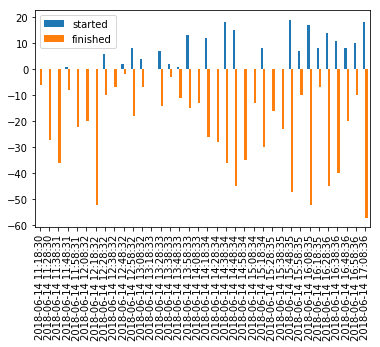

In [129]:
diff_df.plot(kind='bar');